# Denoising Autoencoders for MNIST classification

In [0]:
%matplotlib inline
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
transform = transforms.Compose([transforms.ToTensor()])
BatchSize = 1000

trainset = torchvision.datasets.MNIST(root='./MNIST', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize,
                                          shuffle=True, num_workers=4) # Creating dataloader

testset = torchvision.datasets.MNIST(root='./MNIST', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BatchSize,
                                         shuffle=False, num_workers=4) # Creating dataloader

classes = ('zero', 'one', 'two', 'three',
           'four', 'five', 'six', 'seven', 'eight', 'nine')

In [3]:
# Check availability of GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')

GPU is available!


## Define the Autoencoder:

In [0]:
class L1Penalty(Function):

    @staticmethod
    def forward(self, input, l1weight):
        self.save_for_backward(input)
        self.l1weight = l1weight
        return input

    @staticmethod
    def backward(self, grad_output):
        input, = self.saved_variables
        grad_input = input.clone().sign().mul(self.l1weight)
        grad_input += grad_output
        return grad_input, None

In [8]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.ReLU(),
            nn.Linear(400, 128),
            nn.ReLU())
        self.decoder = nn.Sequential(
            nn.Linear(128,400),
            nn.ReLU(),
            nn.Linear(400,28*28),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
       # x = L1Penalty.apply(x, 0.1) # Uncomment it to add 10% sparsity in the autoencoder
        x = self.decoder(x)
        return x


net = autoencoder()
print(net)

if use_gpu:
    net = net.double().cuda()
else:
    net = net.double()

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=128, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


## Train Autoencoder

In [9]:
iterations = 50
learning_rate = 1e-3
noise_mean = 0.1
noise_std = 0.2
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate) # Adam optimizer for optimization
for epoch in range(iterations):  # loop over the dataset multiple times

    runningLoss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        # wrap them in Variable
        if use_gpu:
            ideal_outputs = Variable(inputs.view(-1, 28*28).double()).cuda()
            # Noise
            noise = Variable(ideal_outputs.data.new(ideal_outputs.size()).normal_(noise_mean, noise_std).double()).cuda()
            # Adding Noise (Noisy Input)
            inputs = Variable(torch.clamp((ideal_outputs + noise).data,0,1).double()).cuda()
        else:
            ideal_outputs = Variable(inputs.view(-1, 28*28).double())
            noise = Variable(ideal_outputs.data.new(ideal_outputs.size()).normal_(noise_mean, noise_std).double())
            inputs = Variable(torch.clamp((ideal_outputs + noise).data,0,1).double())

        optimizer.zero_grad()  # zeroes the gradient buffers of all parameters
        outputs = net(inputs) # forward 
        loss = criterion(outputs, ideal_outputs) # calculate loss
        loss.backward() #  backpropagate the loss
        optimizer.step()
        runningLoss += loss.data
    print('At Iteration : %d / %d  ;  Mean-Squared Error : %f'%(epoch + 1,iterations,
                                                                        runningLoss/(60000/BatchSize)))
print('Finished Training')

At Iteration : 1 / 50  ;  Mean-Squared Error : 0.088127
At Iteration : 2 / 50  ;  Mean-Squared Error : 0.059990
At Iteration : 3 / 50  ;  Mean-Squared Error : 0.044471
At Iteration : 4 / 50  ;  Mean-Squared Error : 0.035104
At Iteration : 5 / 50  ;  Mean-Squared Error : 0.029682
At Iteration : 6 / 50  ;  Mean-Squared Error : 0.025729
At Iteration : 7 / 50  ;  Mean-Squared Error : 0.023150
At Iteration : 8 / 50  ;  Mean-Squared Error : 0.021022
At Iteration : 9 / 50  ;  Mean-Squared Error : 0.019584
At Iteration : 10 / 50  ;  Mean-Squared Error : 0.018237
At Iteration : 11 / 50  ;  Mean-Squared Error : 0.017084
At Iteration : 12 / 50  ;  Mean-Squared Error : 0.016200
At Iteration : 13 / 50  ;  Mean-Squared Error : 0.015440
At Iteration : 14 / 50  ;  Mean-Squared Error : 0.014751
At Iteration : 15 / 50  ;  Mean-Squared Error : 0.014080
At Iteration : 16 / 50  ;  Mean-Squared Error : 0.013492
At Iteration : 17 / 50  ;  Mean-Squared Error : 0.013046
At Iteration : 18 / 50  ;  Mean-Squared 

## Autoencoder Performance:

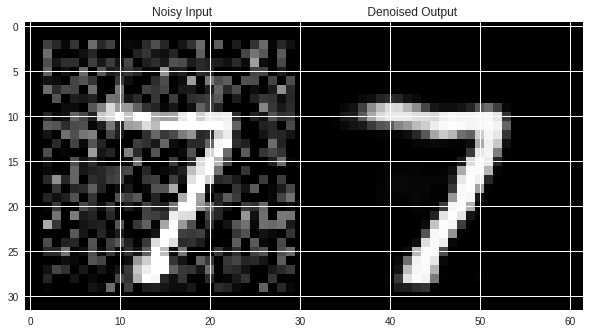

In [10]:
# functions to show an image
def imshow(img, strlabel):
    npimg = img.numpy()
    npimg = np.abs(npimg)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 10
    plt.rcParams["figure.figsize"] = fig_size
    plt.figure()
    plt.title(strlabel)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()

if use_gpu:
    ideal_outputs = Variable(images[0].view(-1,28*28).double()).cuda()
    noise = Variable(ideal_outputs.data.new(ideal_outputs.size()).normal_(noise_mean, noise_std).double()).cuda()
    inputs = ideal_outputs + noise
    outImg = net(inputs).data
    outImg = outImg.view(-1,28,28).cpu()
else:
    ideal_outputs = Variable(images[0].view(-1,28*28).double())
    noise = Variable(ideal_outputs.data.new(ideal_outputs.size()).normal_(noise_mean, noise_std).double())
    inputs = ideal_outputs + noise
    outImg = net(inputs).data
    outImg = outImg.view(-1,28,28)

dispImg = torch.Tensor(2,1,28,28)
dispImg[0] = torch.clamp(inputs.data.view(-1,28,28).cpu(),0,1)
dispImg[1] = outImg

# show images
imshow(torchvision.utils.make_grid(dispImg), 'Noisy Input                                              Denoised Output')

## Modifying the autoencoder for classification:

In [12]:
# Removing the decoder module from the autoencoder
new_classifier = nn.Sequential(*list(net.children())[:-1])
net = new_classifier
# Adding linear layer for 10-class classification problem
net.add_module('classifier', nn.Sequential(nn.Linear(128, 64),nn.ReLU(),
                                          nn.Linear(64, 10),nn.LogSoftmax()))
print(net)
if use_gpu:
    net = net.double().cuda()
else:
    net = net.double()

Sequential(
  (0): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=128, bias=True)
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
    (3): LogSoftmax()
  )
)


## Train Classifier

In [15]:
iterations = 50
learning_rate = 0.1
criterion = nn.NLLLoss()

for epoch in range(iterations):  # loop over the dataset multiple times

    runningLoss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        # wrap them in Variable
        if use_gpu:
            inputs, labels = Variable(inputs.view(-1, 28*28).double()).cuda(), Variable(labels).cuda()
        else:
            inputs, labels = Variable(inputs.view(-1, 28*28).double()), Variable(labels)

        net.zero_grad()  # zeroes the gradient buffers of all parameters
        outputs = net(inputs) # forward 
        loss = criterion(outputs, labels) # calculate loss
        loss.backward() #  backpropagate the loss
        for f in net.parameters():
            f.data.sub_(f.grad.data * learning_rate) # weight = weight - learning_rate * gradient (Update Weights)
        runningLoss += loss.data
        correct = 0
        total = 0
    for data in testloader:
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.view(-1, 28*28).double()).cuda(), labels.cuda()
        else:
            inputs, labels = Variable(inputs.view(-1, 28*28).double()), labels
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    print('At Iteration : %d / %d  ;  Train Error : %f ;Test Accuracy : %f'%(epoch + 1,iterations,
                                                                        runningLoss/(60000/BatchSize),100 *(float(correct) /float(total))))
print('Finished Training')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


At Iteration : 1 / 3  ;  Train Error : 0.059053 ;Test Accuracy : 97.400000
At Iteration : 2 / 3  ;  Train Error : 0.058105 ;Test Accuracy : 97.390000
At Iteration : 3 / 3  ;  Train Error : 0.057216 ;Test Accuracy : 97.460000
Finished Training
